In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

pd.plotting.register_matplotlib_converters()

from math import sqrt
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 18, 8
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

/home/akash/.virtualenvs/cvpy3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/akash/.virtualenvs/cvpy3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('international-airline-passengers.csv',header=None)

In [3]:
df.columns = ['year','passengers']

In [4]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')
y = df.set_index('year')

In [5]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_val = df['passengers'].values
df_val = df_val.reshape(-1, 1)
df_val_scaled = scaler.fit_transform(df_val)
df["scaled_y"] = df_val_scaled

In [6]:
df.head()

,year,passengers,scaled_y
0,1949-01-01,112,0.015444
1,1949-02-01,118,0.027027
2,1949-03-01,132,0.054054
3,1949-04-01,129,0.048263
4,1949-05-01,121,0.032819


In [7]:
for obs in range(1,13):
    df["T_" + str(obs)] = df.scaled_y.shift(obs)

In [8]:
df.fillna(0.00,inplace=True)
df.head(10)

,year,passengers,scaled_y,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,T_10,T_11,T_12
0,1949-01-01,112,0.015444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,1949-02-01,118,0.027027,0.015444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,1949-03-01,132,0.054054,0.027027,0.015444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,1949-04-01,129,0.048263,0.054054,0.027027,0.015444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,1949-05-01,121,0.032819,0.048263,0.054054,0.027027,0.015444,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,1949-06-01,135,0.059846,0.032819,0.048263,0.054054,0.027027,0.015444,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,1949-07-01,148,0.084942,0.059846,0.032819,0.048263,0.054054,0.027027,0.015444,0.000000,0.000000,0.000000,0.0,0.0,0.0
7,1949-08-01,148,0.084942,0.084942,0.059846,0.032819,0.048263,0.054054,0.027027,0.015444,0.000000,0.000000,0.0,0.0,0.0
8,1949-09-01,136,0.061776,0.084942,0.084942,0.059846,0.032819,0.048263,0.054054,0.027027,0.015444,0.000000,0.0,0.0,0.0
9,1949-10-01,119,0.028958,0.061776,0.084942,0.084942,0.059846,0.032819,0.048263,0.054054,0.027027,0.015444,0.0,0.0,0.0


In [9]:
train_data = df[:int(0.6*df.shape[0])]
val_data = df[int(0.6*df.shape[0]):int(0.8*df.shape[0])]
test_data = df[int(0.8*df.shape[0]):]

In [10]:
print(train_data.shape, val_data.shape, test_data.shape)

(86, 15) (29, 15) (29, 15)


In [25]:
x_train = train_data.drop(["passengers" , "year", "scaled_y"], axis = 1)
y_train = train_data["scaled_y"]
x_val = val_data.drop(["passengers", "year", "scaled_y"] , axis = 1)
y_val = val_data["scaled_y"]
x_test = test_data.drop(["passengers", "year", "scaled_y"], axis = 1)
y_test = test_data["scaled_y"]

x_full = df.drop(["passengers" , "year", "scaled_y"], axis = 1)
y_full = df["passengers"]

In [26]:
print(x_train.shape, val_data.shape, test_data.shape)

(86, 12) (29, 15) (29, 15)


In [27]:
"""
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_valid_scaled = scaler.fit_transform(x_val)

x_t_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_reshaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))
"""


'\nfrom sklearn.preprocessing import StandardScaler,MinMaxScaler\nscaler = StandardScaler()\n\nx_train_scaled = scaler.fit_transform(x_train)\nx_test_scaled = scaler.fit_transform(x_test)\nx_valid_scaled = scaler.fit_transform(x_val)\n\nx_t_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))\nx_val_reshaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))\n'

In [28]:

'''
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_valid_scaled = scaler.fit_transform(x_val)
'''

x_train = x_train.values
x_val = x_val.values
x_t_reshaped = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val_reshaped = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [16]:
model_k = Sequential()
model_k.add(LSTM(100, input_shape=(1,12)))
model_k.add(Dropout(0.1))
model_k.add(Dense(1))
model_k.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
history = model_k.fit(x_t_reshaped, y_train, validation_data=(x_val_reshaped, y_val),epochs=100, batch_size=12, verbose=1)

Instructions for updating:
Use tf.cast instead.


Train on 86 samples, validate on 29 samples
Epoch 1/100
86/86 [==============================] - 1s 8ms/step - loss: 0.0358 - val_loss: 0.1126
Epoch 2/100
86/86 [==============================] - 0s 316us/step - loss: 0.0109 - val_loss: 0.0306
Epoch 3/100
86/86 [==============================] - 0s 350us/step - loss: 0.0041 - val_loss: 0.0103
Epoch 4/100
86/86 [==============================] - 0s 392us/step - loss: 0.0043 - val_loss: 0.0105
Epoch 5/100
86/86 [==============================] - 0s 347us/step - loss: 0.0043 - val_loss: 0.0098
Epoch 6/100
86/86 [==============================] - 0s 351us/step - loss: 0.0030 - val_loss: 0.0115
Epoch 7/100
86/86 [==============================] - 0s 331us/step - loss: 0.0029 - val_loss: 0.0111
Epoch 8/100
86/86 [==============================] - 0s 311us/step - loss: 0.0030 - val_loss: 0.0103
Epoch 9/100
86/86 [==============================] - 0s 358us/step - loss: 0.0027 - val_loss: 0.0101
Epoch 10/100
86/86 [=============================

In [29]:
x_test = x_test.values
x_te_reshaped = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

x_full_arr = x_full.values
x_full_reshaped = x_full_arr.reshape((x_full.shape[0], 1, x_full.shape[1]))

In [30]:
res_tr = model_k.predict(x_t_reshaped)
res_val = model_k.predict(x_val_reshaped)
res_test = model_k.predict(x_te_reshaped)

res_full = model_k.predict(x_full_reshaped)

In [31]:
print(res_tr.shape, res_val.shape,res_test.shape)

(86, 1) (29, 1) (29, 1)


In [32]:
y_pred_tr = scaler.inverse_transform(res_tr)
y_pred_val = scaler.inverse_transform(res_val)
y_pred_test = scaler.inverse_transform(res_test)
y_act = df["passengers"].values

y_full= scaler.inverse_transform(res_full)

In [33]:
look_back = 12

In [34]:

# shift train predictions for plotting
all_y = df["scaled_y"].values

dataset= all_y.reshape(-1, 1)
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
#print(trainPredictPlot)
trainPredictPlot[:len(y_pred_tr), :] = y_pred_tr

valPredictPlot = np.empty_like(dataset)
valPredictPlot[:, :] = np.nan
#print(trainPredictPlot)
valPredictPlot[len(y_pred_tr) : len(y_pred_tr) + len(y_pred_val), :] = y_pred_val

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#print(trainPredictPlot)
testPredictPlot[len(y_pred_tr) + len(y_pred_val):, :] = y_pred_test

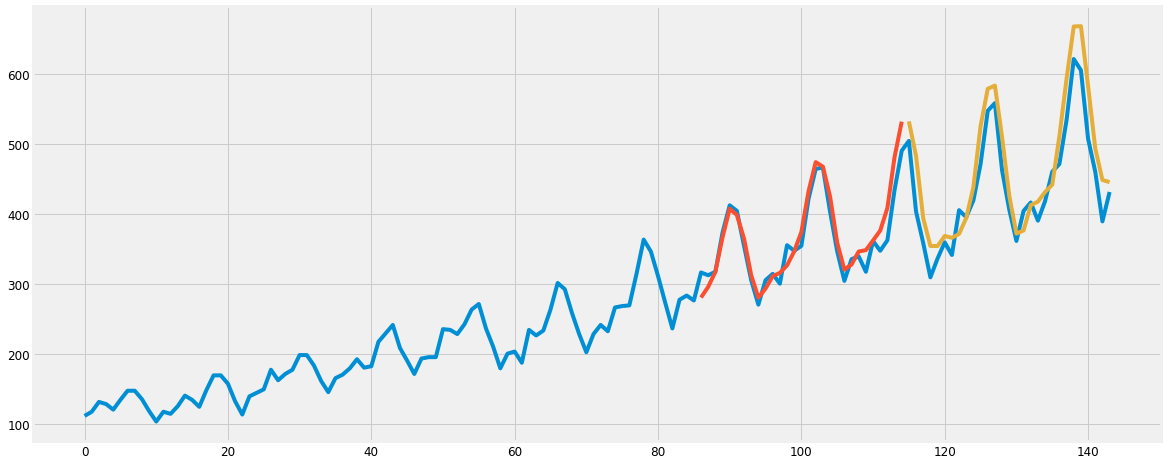

In [35]:
matplotlib.rcParams['figure.figsize'] = 18, 8
plt.plot(y_act)
plt.plot(valPredictPlot)
plt.plot(testPredictPlot)


In [51]:
#R^2

from sklearn.metrics import r2_score
print(r2_score(y_act, y_full)*100)

96.53942954370085


In [43]:
np.savetxt("LSTM_RESULT.csv", y_act)

In [40]:
print(y_act)

[112 118 132 129 121 135 148 148 136 119 104 118 115 126 141 135 125 149
 170 170 158 133 114 140 145 150 178 163 172 178 199 199 184 162 146 166
 171 180 193 181 183 218 230 242 209 191 172 194 196 196 236 235 229 243
 264 272 237 211 180 201 204 188 235 227 234 264 302 293 259 229 203 229
 242 233 267 269 270 315 364 347 312 274 237 278 284 277 317 313 318 374
 413 405 355 306 271 306 315 301 356 348 355 422 465 467 404 347 305 336
 340 318 362 348 363 435 491 505 404 359 310 337 360 342 406 396 420 472
 548 559 463 407 362 405 417 391 419 461 472 535 622 606 508 461 390 432]


In [44]:
np.savetxt("LSTM_RESULT_my.csv", y_full)

In [57]:
print(r2_score(y_act[int(0.77*len(y_act)):] , y_full[int(0.77*len(y_full)): ])*100)

74.4905221023214


In [48]:
y_act[int(0.75*len(y_act)):]

array([340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337, 360,
       342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405, 417, 391,
       419, 461, 472, 535, 622, 606, 508, 461, 390, 432])